# View Fors2 , View spectra one by one and Compare to SL and write in a pdf file

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/01/21
- last update : 2023/03/20
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2

## Import

In [1]:
import os,sys,re
from astropy.io import fits
from astropy.table import Table

In [2]:
# Import some generally useful packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice


In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'image.cmap':'jet'}
plt.rcParams.update(params)

In [5]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [6]:
from StudyFors2SED.def_raw_seds import *

In [7]:
from StudyFors2SED.raw_data_analysis import *

In [8]:
# Import the primary photometry classes from rubin_sim.photUtils

#import rubin_sim.phot_Utils.Bandpass as Bandpass
#import rubin_sim.phot_Utils.Sed as Sed
#from rubin_sim.data import get_data_dir

In [9]:
#pysynphot_root_path=os.environ['PYSYN_CDBS']
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
#import pysynphot as S
#S.refs.setref(area=1)
#S.refs.getref()

In [10]:
from astropy.io import fits

In [11]:
from scipy.ndimage import gaussian_filter1d

In [12]:
from tqdm import tqdm
import jax.numpy as jnp
from jax import jit, vmap

In [13]:
#from StudyFors2SED.GalaxyLineDict import build_emissionlinesdict

In [14]:
def build_emissionlinesdict():
    """  
    Build a dictionnary of lines in galaxies
    
    """
    
    
    #http://astronomy.nmsu.edu/drewski/tableofemissionlines.html
    #https://classic.sdss.org/dr6/algorithms/linestable.html



    df_lines=pd.read_excel("StudyFors2SED/datatools/GalEmissionLines.xlsx")
    df_sdss_lines = pd.read_excel("StudyFors2SED/datatools/sdss_galaxylines.xlsx")
    
    lines_to_plot={}
    
    # K
    sel = df_sdss_lines["species"] == 'K'
    wls = df_sdss_lines[sel]["wl"].values
    lines_to_plot["K"]={"wls":wls,"name":"K","type":"absorption"}
    
    # H
    sel = df_sdss_lines["species"] == 'H'
    wls = df_sdss_lines[sel]["wl"].values
    lines_to_plot["H"]={"wls":wls,"name":"H","type":"absorption"}
    
    # G
    sel = df_sdss_lines["species"] == 'G'
    wls = df_sdss_lines[sel]["wl"].values
    lines_to_plot["G"]={"wls":wls,"name":"G","type":"absorption"}
    
    # Mg
    sel = df_sdss_lines["species"] == 'Mg'
    wls = df_sdss_lines[sel]["wl"].values
    lines_to_plot["Mg"]={"wls":wls,"name":"Mg","type":"absorption"}
    
    # Na
    sel = df_sdss_lines["species"] == 'Na'
    wls = df_sdss_lines[sel]["wl"].values
    lines_to_plot["Na"]={"wls":wls,"name":"Na","type":"absorption"}
    
    # H8
    sel = df_lines["ion"] == 'H8'
    wls = df_lines[sel]["wl"].values
    lines_to_plot["H8"]={"wls":wls,"name":"$H8$","type":"emission"}
    
    # H9
    sel = df_lines["ion"] == 'H9'
    wls = df_lines[sel]["wl"].values
    lines_to_plot["H9"]={"wls":wls,"name":"$H9$","type":"emission"}
    
    # H10
    sel = df_lines["ion"] == 'H10'
    wls = df_lines[sel]["wl"].values
    lines_to_plot["H10"]={"wls":wls,"name":"$H10$","type":"emission"}
    
    # H11
    sel = df_lines["ion"] == 'H11'
    wls = df_lines[sel]["wl"].values
    lines_to_plot["H11"]={"wls":wls,"name":"$H11$","type":"emission"}
    
    # Halpha
    sel = df_lines["ion"] == 'Hα' 
    wls=df_lines[sel]["wl"].values
    lines_to_plot["H{alpha}"]={"wls":wls,"name":"$H_\\alpha$","type":"emission"}
    
    
    # Hbeta
    sel = df_lines["ion"] == 'Hβ' 
    wls=df_lines[sel]["wl"].values
    lines_to_plot["H{beta}"]={"wls":wls,"name":"$H_\\beta$","type":"emission"}

    # Hgamma
    sel = df_lines["ion"] == 'Hγ' 
    wls=df_lines[sel]["wl"].values
    lines_to_plot["H{gamma}"]={"wls":wls,"name":"$H_\\gamma$","type":"emission"}
    
    # Hdelta
    sel = df_lines["ion"] == 'Hδ' 
    wls=df_lines[sel]["wl"].values
    lines_to_plot["H{delta}"]={"wls":wls,"name":"$H_\\delta$","type":"emission"}
    
    # Hepsilon
    sel = df_lines["ion"] == 'Hε' 
    wls=df_lines[sel]["wl"].values
    lines_to_plot["H{epsilon}"]={"wls":wls,"name":"$H_\\epsilon$","type":"emission"}
    
    
    sel = df_lines["ion"] == '[O II]'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["[OII]"]={"wls":wls,"name":"$[OII]$","type":"emission"}
    
    
    sel = df_lines["ion"] == '[O III]'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["[OIII]"]={"wls":wls,"name":"$[OIII]$","type":"emission"}
    
    
    sel = df_lines["ion"] == 'O IV]'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["[OIV]"]={"wls":wls,"name":"$[OIV]$","type":"emission"}
    
    
    sel = df_lines["ion"] == 'O VI'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["[OVI]"]={"wls":wls,"name":"$[OVI]$","type":"emission"}
    
    
    sel = df_lines["ion"] == 'Mgb'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["Mgb"]={"wls":wls,"name":"$Mgb$","type":"emission"}
    
    
    sel = df_lines["ion"] == 'Mg II]'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["MgII"]={"wls":wls,"name":"$MgII$","type":"emission"}
    
    
    sel = df_lines["ion"] == 'Fe43'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["Fe43"]={"wls":wls,"name":"$Fe43$","type":"emission"}
    
    sel = df_lines["ion"] == 'Fe45'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["Fe45"]={"wls":wls,"name":"$Fe45$","type":"emission"}
    
    sel = df_lines["ion"] == 'Ca44'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["Ca44"]={"wls":wls,"name":"$Ca44$","type":"emission"}
    
    
    sel = df_lines["ion"] == 'Ca44'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["Ca44"]={"wls":wls,"name":"$Ca44$","type":"emission"}
    
    sel = df_lines["ion"] == 'E'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["E"]={"wls":wls,"name":"$E$","type":"emission"}
    
    sel = df_lines["ion"] =='Fe II'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["FeII24"]={"wls":wls,"name":"$FeII24$","type":"emission"}
    lines_to_plot['FeII26']={"wls":wls,"name":"$FeII26$","type":"emission"}
    
    
    lines_to_plot['weak']={"wls":[],"name":"$weak$","type":"break"}
    lines_to_plot['?']={"wls":[],"name":"$?$","type":"break"}
    
    lines_to_plot['4000{AA}-break']={"wls":[4000.],"name":"$Bal$","type":"break"}
     
    sel = df_lines["ion"] == 'Lyα'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["Ly{alpha}"]={"wls":wls,"name":"$Ly_\\alpha$","type":"emission"}
    
    sel = df_lines["ion"] == 'Lyβ'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["Ly{beta}"]={"wls":wls,"name":"$Ly_\\beta$","type":"emission"}
    
    
    sel = df_lines["ion"] == 'Lyδ'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["Ly{delta}"]={"wls":wls,"name":"$Ly_\\delta$","type":"emission"}
    
    
    sel = df_lines["ion"] == 'Lyε'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["Ly{epsilon}"]={"wls":wls,"name":"$Ly_\\epsilon$","type":"emission"}
    
    sel = df_lines["ion"] == 'C IV'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["CIV"]={"wls":wls,"name":"$CIV$","type":"emission"}
    
    sel = df_lines["ion"] == 'Al III'
    wls=df_lines[sel]["wl"].values
    lines_to_plot["AlIII"]={"wls":wls,"name":"$AlIII$","type":"emission"}
    
    
    sel = df_lines["ion"] == '[Ne III]'
    wls=df_lines[sel]["wl"].values
    lines_to_plot['NeIII']={"wls":wls,"name":"$NeIII$","type":"emission"}
    
    sel = df_lines["ion"] == 'He I'
    wls=df_lines[sel]["wl"].values
    lines_to_plot['HeI']={"wls":wls,"name":"$HeI$","type":"emission"}
    
    sel = df_lines["ion"] == 'N III'
    wls=df_lines[sel]["wl"].values
    lines_to_plot['NIII']={"wls":wls,"name":"$NIII$","type":"emission"}
    
    sel = df_lines["ion"] == 'Al II'
    wls=df_lines[sel]["wl"].values
    lines_to_plot['AlII']={"wls":wls,"name":"$AlII$","type":"emission"}
    
    sel = df_lines["ion"] == 'Al III'
    wls=df_lines[sel]["wl"].values
    lines_to_plot['AlIII']={"wls":wls,"name":"$AlIII$","type":"emission"}
    
    
    sel = df_lines["ion"] == '[N II]'
    wls=df_lines[sel]["wl"].values
    lines_to_plot['NII']={"wls":wls,"name":"$NII$","type":"emission"}
    
    sel = df_lines["ion"] == 'C III'
    wls=df_lines[sel]["wl"].values
    lines_to_plot['CIII']={"wls":wls,"name":"$CIII$","type":"emission"}
    
    sel = df_lines["ion"] == 'C IV'
    wls=df_lines[sel]["wl"].values
    lines_to_plot['CIV']={"wls":wls,"name":"$CIV$","type":"emission"}
    
    sel = df_sdss_lines["species"] == 'Si IV + O IV'
    wls=df_sdss_lines[sel]["wl"].values
    lines_to_plot['SiIV/OIV']={"wls":wls,"name":"$SiIV/OIV$","type":"emission"}
    
    lines_to_plot["(QSO)"] = {"wls":[],"name":"$QSO$","type":"emission"}
    lines_to_plot["QSO"] = {"wls":[],"name":"$QSO$","type":"emission"}
    
    lines_to_plot['NaD'] = {"wls":[],"name":"$NaD$","type":"emission"}
    
    lines_to_plot['broad'] = {"wls":[],"name":"$broad$","type":"emission"}
    
    return lines_to_plot

In [15]:
from matplotlib.backends.backend_pdf import PdfPages

In [16]:
import copy

In [17]:
def SaveImageInPdf(all_figs,outputfile):
    """
    """
    with PdfPages(outputfile) as pdf:
        for fig in all_figs:
            pdf.savefig(fig)
            plt.close()

# Start

In [18]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /home/joseph/PhotoZ_PhD


# Lines

In [19]:
lines_to_plot=build_emissionlinesdict()

In [20]:
lines_to_plot

{'K': {'wls': array([3934.777]), 'name': 'K', 'type': 'absorption'},
 'H': {'wls': array([4341.68 , 4862.68 , 6564.61 , 3969.588]),
  'name': 'H',
  'type': 'absorption'},
 'G': {'wls': array([4305.61]), 'name': 'G', 'type': 'absorption'},
 'Mg': {'wls': array([5176.7]), 'name': 'Mg', 'type': 'absorption'},
 'Na': {'wls': array([5895.6]), 'name': 'Na', 'type': 'absorption'},
 'H8': {'wls': array([3889.064]), 'name': '$H8$', 'type': 'emission'},
 'H9': {'wls': array([3835.391]), 'name': '$H9$', 'type': 'emission'},
 'H10': {'wls': array([3797.904]), 'name': '$H10$', 'type': 'emission'},
 'H11': {'wls': array([3770.637]), 'name': '$H11$', 'type': 'emission'},
 'H{alpha}': {'wls': array([6562.819]),
  'name': '$H_\\alpha$',
  'type': 'emission'},
 'H{beta}': {'wls': array([4861.333]),
  'name': '$H_\\beta$',
  'type': 'emission'},
 'H{gamma}': {'wls': array([4340.471]),
  'name': '$H_\\gamma$',
  'type': 'emission'},
 'H{delta}': {'wls': array([4101.742]),
  'name': '$H_\\delta$',
  'type

In [21]:
def plot_line(ax,line_name):
    
    #keys = lines_to_plot.keys()
    #for the_key in keys:
    #    if the_key in line_name:
    #        print("the_key=",the_key," line_name=",line_name)
    #        line_name=the_key
    #        break
            
    posx0=0.0
    posy0=0.05
    fontsize=12
    the_color = {"emission":'r',"absorption":"g","break":"purple"}
    the_line_to_plot = lines_to_plot[line_name]
    wls = the_line_to_plot["wls"]
    tag = the_line_to_plot["name"]
    typ = the_line_to_plot["type"]
    
    xlim = ax.get_xlim()
    for wl in wls:
        ax.axvline(wl, lw=2, color=the_color[typ])
        xpos = (wl - xlim[0]) / (xlim[1] - xlim[0])+posx0 
        if 0 < xpos < 1:
            ax.annotate(tag, xy=(xpos, posy0), rotation=0, ha='left', va='bottom',
                            xycoords='axes fraction', color=the_color[typ], fontsize=fontsize)
    return ax

## StarLight

In [22]:
filename = 'StudyFors2SED/datatools/spectra_SL_data.fits'
hdu = fits.open(filename)
data_in=hdu[0].data
hdr_in = hdu[0].header

In [23]:
hdr_in

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6362                                                  
NAXIS2  =                  553                                                  
DATAWLS = 'data[0,1:]'                                                          
DATALLAV= 'data[1,1:]'                                                          
DATALLST= 'data[2,1:]'                                                          
DATAFL  = 'data[3:,1:]'                                                         
DATANUM = 'data[3:,0]'                                                          
COMMENT Spectra of StarLight                                                    

In [24]:
NSED_SL = data_in.shape[0]-3
NWL_SL = data_in.shape[1]-1

In [25]:
wavelengths_SL = data_in[0,1:] 
flambdas_average_SL = data_in[1,1:] 
flambdas_std_SL = data_in[2,1:] 
spec_SL = data_in[3:,1:] 
all_numbers_SL = data_in[3:,0] 

### Fors2

## Start

### Catalog

In [26]:
t = Table.read(filename_fits_catalog)
t_fits = fits.open(filename_fits_catalog)
t_data = t_fits[0].data
t_hdr= t_fits[0].header

In [27]:
t

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
1,,13.52815,-28.40486,0.55409,,20.79,166227,55,10.0,1,"[OII],H8,K,H"
2,,13.52997,-28.44776,0.34555,,21.18,103665,40,12.3,1,"K,H,G,H{beta}"
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"
4,,13.52216,-28.40914,0.68653,,21.62,205959,123,10.6,1,"[OII],H9,K,H,G,H{beta}"
7,,13.50974,-28.42972,0.32371,,22.34,97111,11,16.7,6,"[OII],H{beta},[OIII],H{alpha}"
9,,13.50219,-28.40641,0.29266,,21.6,87798,58,13.1,1,"H9,H8,K,H"
11,,13.49724,-28.39487,0.62688,,22.09,188063,17,24.3,3,"[OII],H10,H8,K,H,H{delta}"
12,,13.49584,-28.39125,0.2973,,21.97,89189,30,14.8,2,"[OII],H10,H9,H8,K,H"


In [28]:
t_hdr

SIMPLE  =                    T / Standard FITS Format                           
BITPIX  =                    8 / Character data                                 
NAXIS   =                    0 / No Image --- just extension(s)                 
EXTEND  =                    T / There are standard extensions                  
ORIGIN  = 'xml2fits_v1.95'     / Converted from XML-Astrores to FITS            
                         e-mail: question@simbad.u-strasbg.fr                   
LONGSTRN= 'OGIP 1.0'           / Long string convention (&/CONTINUE) may be used
DATE    = '2016-11-14'         / Written on 2016-11-14:16:30:25 (GMT)           
                             by: apache@vizier.u-strasbg.fr                     
         **********************************************************             
             EXCERPT from catalogues stored in VizieR (CDS)                     
                        with the following conditions:                          
         *******************

### List

In [29]:
lst=fors2_jct_SL() #remet les spectres dans le rest frame (ie a z=0)

In [30]:
all_specfilenames = os.listdir(path_out_jct)

In [31]:
all_specfilenames = sorted(all_specfilenames)

In [32]:
all_numbers = [ int(re.findall('^SPEC(.*)[.]txt$',fn)[0]) for fn in all_specfilenames ]

In [33]:
all_numbers = sorted(all_numbers)

In [34]:
NSED = len(all_numbers)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [35]:
cut = t["ID"] == 3
t[cut]

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"


In [36]:
all_spectra = []
all_wl = []
all_tag = []
all_lines = []
#all_sed = []
all_redshifts = []
all_num = []
all_ra = []
all_dec = []

for idx,the_num in enumerate(all_numbers):
    tcut = t["ID"] == the_num
    redshift = t[tcut]["z"].value[0]
    lines = t[tcut]["Lines"].value[0]
    ra = t[tcut]["RAJ2000"].value[0]
    dec = t[tcut]["DEJ2000"].value[0]
    filename = f"SPEC{the_num}.txt"
    tag = f"SPEC{the_num} , z={redshift:.2f}, lines={lines.decode().split(' ')[0]}"
    fullfilename = os.path.join(path_out_jct,filename)

    arr = np.loadtxt(fullfilename)
    all_wl.append(arr[:,0])
    all_spectra.append(arr[:,1])
    all_tag.append(tag)
    all_lines.append(lines) 
    all_redshifts.append(redshift)
    all_num.append(the_num) 
    all_ra.append(ra) 
    all_dec.append(dec)

#all_wl = np.array(all_wl)
#all_spectra = np.array(all_spectra)
all_tag = np.array(all_tag)
all_lines = np.array(all_lines)
all_redshifts = np.array(all_redshifts)
all_num = np.array(all_num)
all_ra = np.array(all_ra)
all_dec = np.array(all_dec)

the_lines =  b'K,H,H{delta},G                                                              \r'
K
H
H{delta}
G


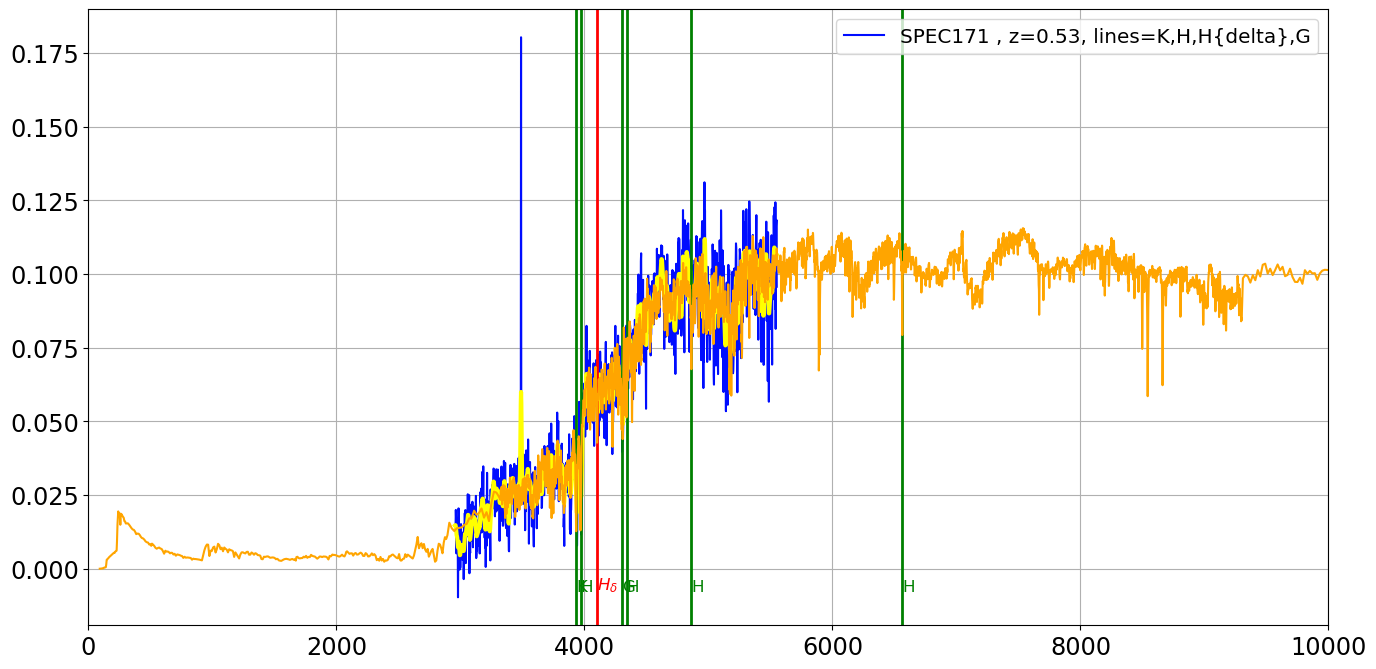

In [37]:
idx=np.where(np.asarray(all_numbers) == 171)[0][0]
the_lines = all_lines[idx]
print("the_lines = ",the_lines)

all_elements  = the_lines.decode().split(",")


fig, axs = plt.subplots(1, 1, figsize=(16, 8))
ax=axs
the_wl_fors2 = all_wl[idx]
the_flux_fors2 = all_spectra[idx]
the_max_flux_1 = the_wl_fors2.max()
ax.plot(the_wl_fors2 ,the_flux_fors2 ,'-' ,color=all_colors[idx],label=all_tag[idx])

the_flux_fors2_filt  = gaussian_filter1d(the_flux_fors2,2)
ax.plot(the_wl_fors2 ,the_flux_fors2_filt ,'-' ,color='yellow',lw=3)

wlmin = the_wl_fors2.min()
wlmax = the_wl_fors2.max()

I1=np.trapz(the_flux_fors2_filt ,the_wl_fors2)

ax.legend(loc="upper right")
ax.grid()

wl1=4150
wl2=4250

#ax.axvline(wl1,color="grey")
#ax.axvline(wl2,color="grey")




#    plt.ylim(-0.02,0.4)
ax.set_xlim(0.,10000.)
for el in all_elements:
    el=el.split(" ")[0]  
    print(el)
    if len(el)>0:
        plot_line(ax,el)

        
the_num = all_numbers[idx]

idx_sl=np.where(all_numbers_SL==the_num)[0][0]
the_spectrum_SL = spec_SL[idx_sl]

the_max_flux_2 = the_spectrum_SL.max()

wavelengths_SL_indexes=np.where(np.logical_and(wavelengths_SL>=wlmin,wavelengths_SL<wlmax))[0]

the_spectrum_SL_flux_cut = the_spectrum_SL[wavelengths_SL_indexes]
the_spectrum_SL_wl_cut = wavelengths_SL[wavelengths_SL_indexes]

I2=np.trapz(the_spectrum_SL_flux_cut,the_spectrum_SL_wl_cut)

g=I1/I2

the_flux_SL_toplot= g*spec_SL[idx_sl]

the_max_flux_2=the_flux_SL_toplot.max()

ymax=1.1*max(the_max_flux_1,the_max_flux_2)

ax.plot(wavelengths_SL,the_flux_SL_toplot,color="orange")

ymin=0

#ax.set_ylim(ymin,ymax)

the_lines =  b'K,H,H{delta},G                                                              \r'
K
H
H{delta}
G
K
H
H{delta}
G


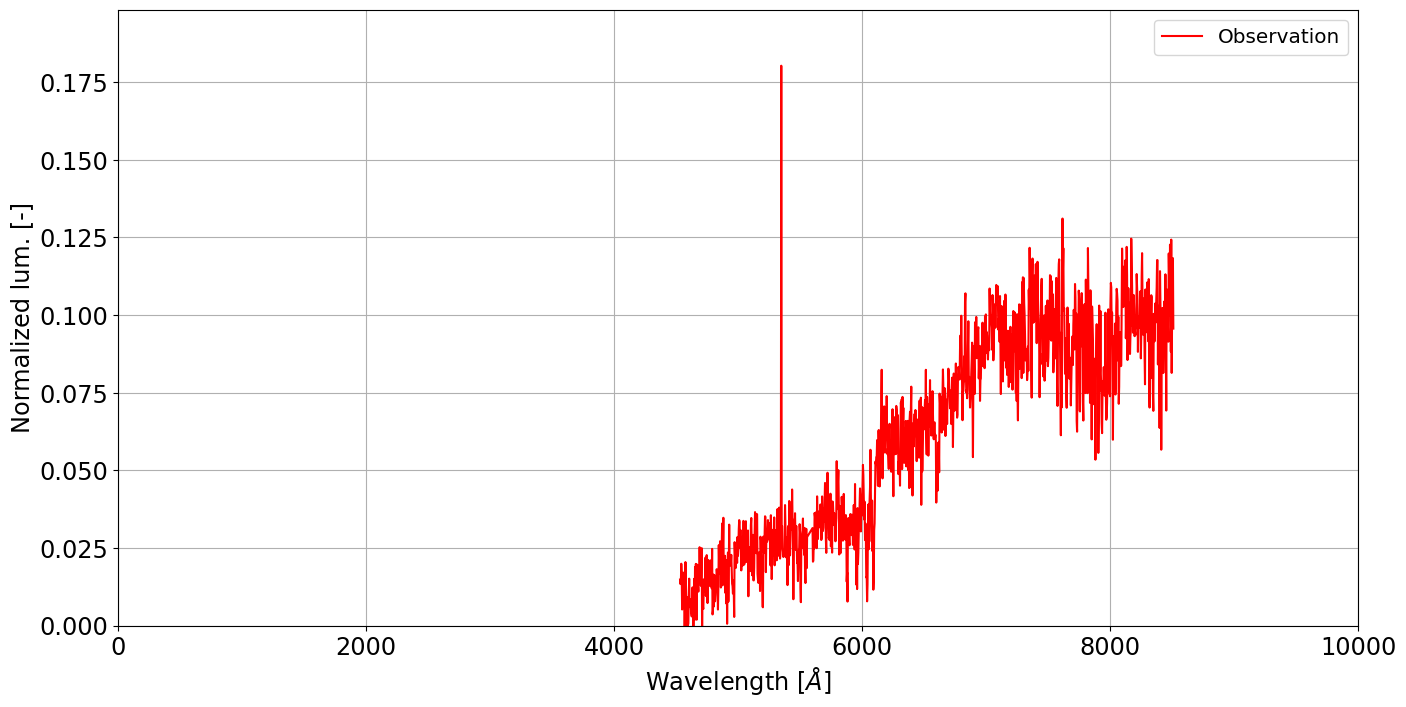

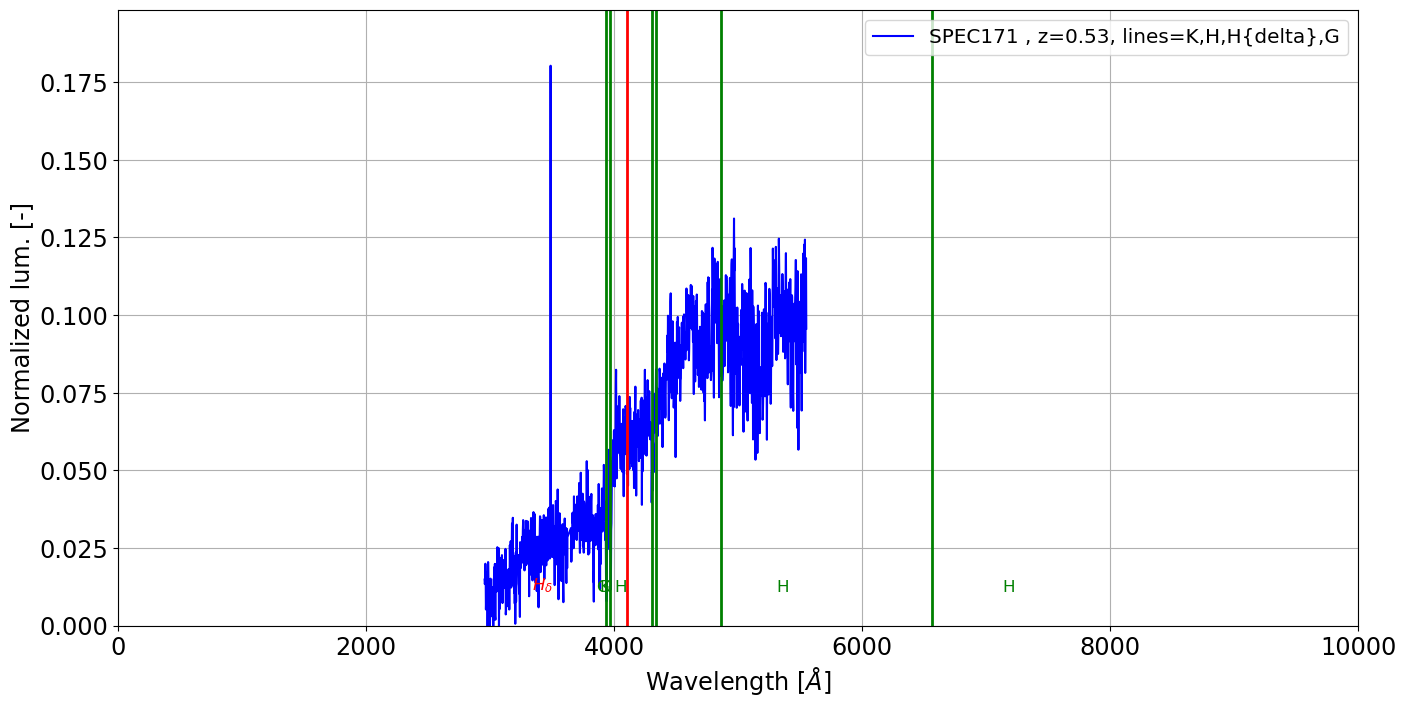

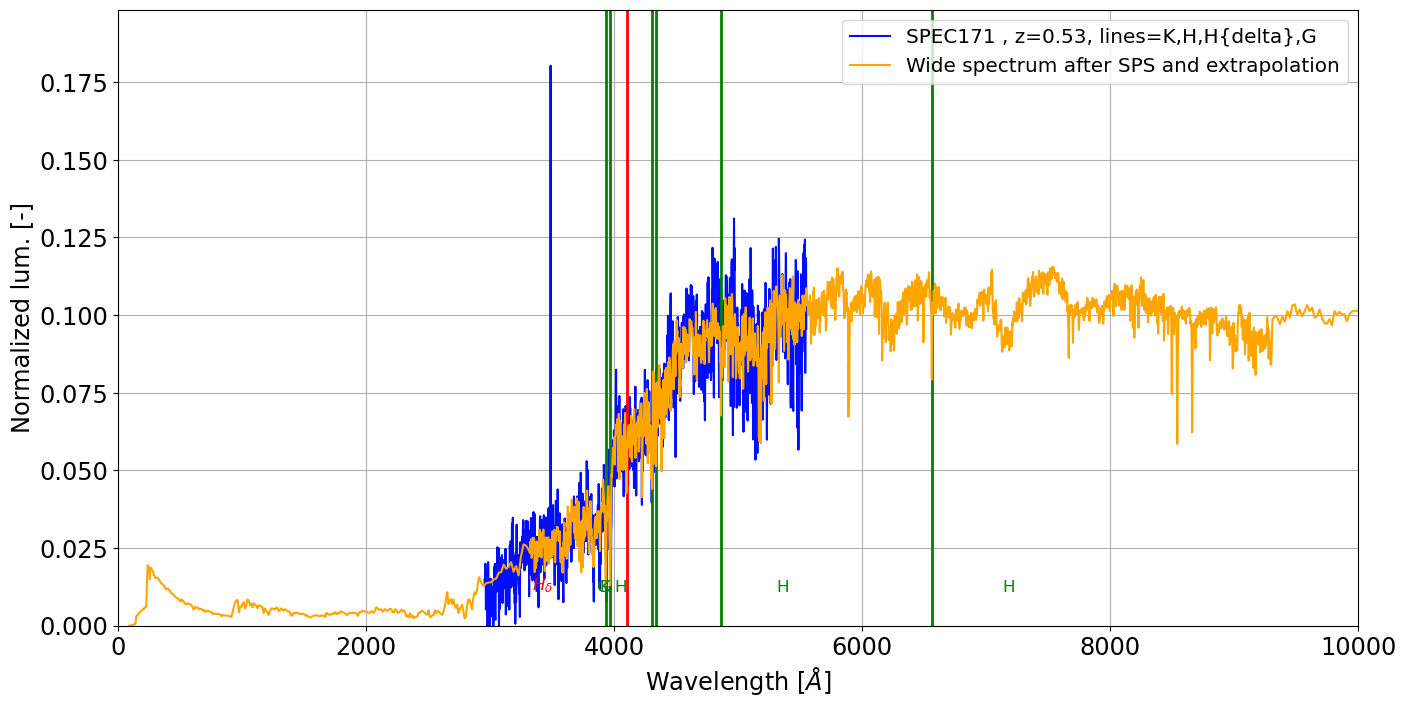

In [38]:
idx=np.where(np.asarray(all_numbers) == 171)[0][0]
the_lines = all_lines[idx]
print("the_lines = ",the_lines)
all_elements  = the_lines.decode().split(",")

the_wl_fors2 = all_wl[idx]
the_flux_fors2 = all_spectra[idx]
the_max_flux_1 = the_flux_fors2.max()

wlmin = the_wl_fors2.min()
wlmax = the_wl_fors2.max()

I1=np.trapz(the_flux_fors2_filt ,the_wl_fors2)

wl1=4150
wl2=4250

#ax.axvline(wl1,color="grey")
#ax.axvline(wl2,color="grey")
        
the_num = all_numbers[idx]
z=all_redshifts[idx]

idx_sl=np.where(all_numbers_SL==the_num)[0][0]
the_spectrum_SL = spec_SL[idx_sl]
the_max_flux_2 = the_spectrum_SL.max()
wavelengths_SL_indexes=np.where(np.logical_and(wavelengths_SL>=wlmin,wavelengths_SL<wlmax))[0]
the_spectrum_SL_flux_cut = the_spectrum_SL[wavelengths_SL_indexes]
the_spectrum_SL_wl_cut = wavelengths_SL[wavelengths_SL_indexes]

I2=np.trapz(the_spectrum_SL_flux_cut,the_spectrum_SL_wl_cut)

g=I1/I2
the_flux_SL_toplot= g*spec_SL[idx_sl]
the_max_flux_2=the_flux_SL_toplot.max()

ymax=1.1*max(the_max_flux_1,the_max_flux_2)
ymin=0

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(the_wl_fors2*(1+z), the_flux_fors2, '-', color='red', label="Observation")
ax.set_xlim(0.,10000.)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("Wavelength [$\AA$]")
ax.set_ylabel("Normalized lum. [-]")
ax.legend(loc="upper right")
ax.grid()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(the_wl_fors2 ,the_flux_fors2 ,'-' ,color='blue',label=all_tag[idx])
for el in all_elements:
    el=el.split(" ")[0]  
    print(el)
    if len(el)>0:
        plot_line(ax,el)
ax.set_xlim(0.,10000.)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("Wavelength [$\AA$]")
ax.set_ylabel("Normalized lum. [-]")
ax.legend(loc="upper right")
ax.grid()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(the_wl_fors2, the_flux_fors2, '-', color=all_colors[idx], label=all_tag[idx])
#ax.set_ylim(-0.02,0.4)
for el in all_elements:
    el=el.split(" ")[0]  
    print(el)
    if len(el)>0:
        plot_line(ax,el)
ax.plot(wavelengths_SL, the_flux_SL_toplot, color="orange", label="Wide spectrum after SPS and extrapolation")
ax.set_xlim(0.,10000.)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("Wavelength [$\AA$]")
ax.set_ylabel("Normalized lum. [-]")
ax.legend(loc="upper right")
ax.grid()

## Position of SL galaxies vs redshifts

In [39]:
if False:
    # Compute the metric distance dmet in Mpc : dlum = dmet*(1+z), dang = dmet/(1+z) = dlum/(1+z)^2
    ckms = 2.99792458e5 # en km/s
    def distMet(z, h0=70., om0=0.3, l0=0.7):
        dmet, ao = 0., 1.
        # case without the cosmological constant
        if (l0==0):
            # ao = c/(self.h0*np.sqrt(np.abs(1-self.omt)))
            # in fact we use x = ao * x(z) with x(z) from eq 8 of
            # Moscardini et al.  So we don't need to compute ao
            if (om0>0):
                dmet = om0*z-(om0-2)*(1-np.sqrt(1+om0*z))
                dmet = 2*ckms/(ao*h0*om0*om0*(1+z))*dmet
            else:
                dmet = ckms*z*(1.+z/2.)/(h0*(1+z))

        elif (om0<1 and l0 != 0):
            _sum = 0.
            dz = z/50.
            for i in range(50):
                zi = (i+0.5)*dz
                Ez = np.sqrt(om0*np.power((1.+zi),3.)+(1-om0-l0)*np.power((1.+zi),2.)+l0)
                _sum = _sum + dz/Ez
            dmet = ckms/(h0*ao) * _sum
        else:
            raise RuntimeError(f"Cosmology not included : h0={h0}, Om0={om0}, l0={l0}")
        return dmet

In [40]:
from StudyFors2SED import comov_dist

In [41]:
_sel = (all_redshifts < 1.5)

In [42]:
all_dists = np.array([comov_dist.comoving_dist(0.292, Z)/comov_dist.mpc_m for Z in all_redshifts[_sel]])

In [43]:
cw_map = plt.get_cmap('coolwarm')
cNorm2 = colors.Normalize(vmin=0, vmax=1.) # np.max(all_redshifts))
scalarMap2 = cmx.ScalarMappable(norm=cNorm2, cmap=cw_map)
all_colors2 = scalarMap2.to_rgba(all_redshifts[_sel], alpha=1)

In [44]:
ra0, dec0 = (54/60*15)/180*np.pi, -(28.+23/60)/180*np.pi
angles_to_center = (180/np.pi)*np.arccos(np.sin(all_ra[_sel]/180*np.pi)*np.sin(ra0)+np.cos(all_ra[_sel]/180*np.pi)*np.cos(ra0)*np.cos(all_dec[_sel]/180*np.pi-dec0))

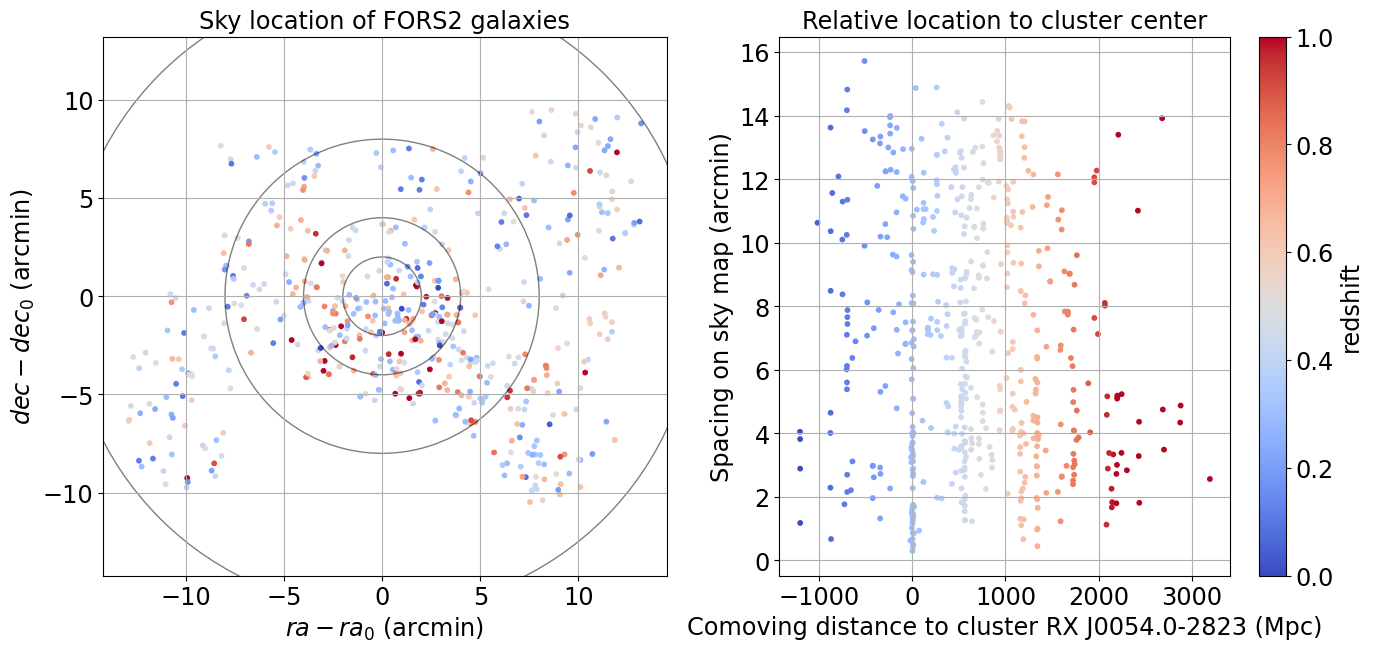

In [45]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
a1,a2 = axs.ravel()
a1.scatter((all_ra[_sel]-ra0*180/np.pi)*60, (all_dec[_sel]-dec0*180/np.pi)*60,c=all_colors2, edgecolors=all_colors2, s=10,marker="o",alpha=1)
#im = ax.scatter(all_ra,all_dec,c=all_redshifts,s=10,marker="o",alpha=0.5,cmap="jet")
a1.axis('equal')
a1.grid()
c1=plt.Circle((0.,0.), 2., fill=False, alpha=0.5, label="Spacing: 2 arcmin")
c2=plt.Circle((0.,0.), 4., fill=False, alpha=0.5, label="Spacing: 4 arcmin")
c3=plt.Circle((0.,0.), 8., fill=False, alpha=0.5, label="Spacing: 6 arcmin")
c4=plt.Circle((0.,0.), 16., fill=False, alpha=0.5, label="Spacing: 8 arcmin")
a1.add_artist(c1)
a1.add_artist(c2)
a1.add_artist(c3)
a1.add_artist(c4)
a1.set_xlabel("$ra-ra_0$ (arcmin)")
a1.set_ylabel("$dec-dec_0$ (arcmin)")
a1.set_title("Sky location of FORS2 galaxies")
#a1.legend()

a2.scatter(all_dists,angles_to_center*60,c=all_colors2, edgecolors=all_colors2, s=10,marker="o",alpha=1)
#im = ax.scatter(all_ra,all_dec,c=all_redshifts,s=10,marker="o",alpha=0.5,cmap="jet")
a2.grid()
a2.set_xlabel("Comoving distance to cluster RX J0054.0-2823 (Mpc)")
a2.set_ylabel("Spacing on sky map (arcmin)")
a2.set_title("Relative location to cluster center")

cbar = fig.colorbar(scalarMap2, ax=a2)
cbar.set_label('redshift')

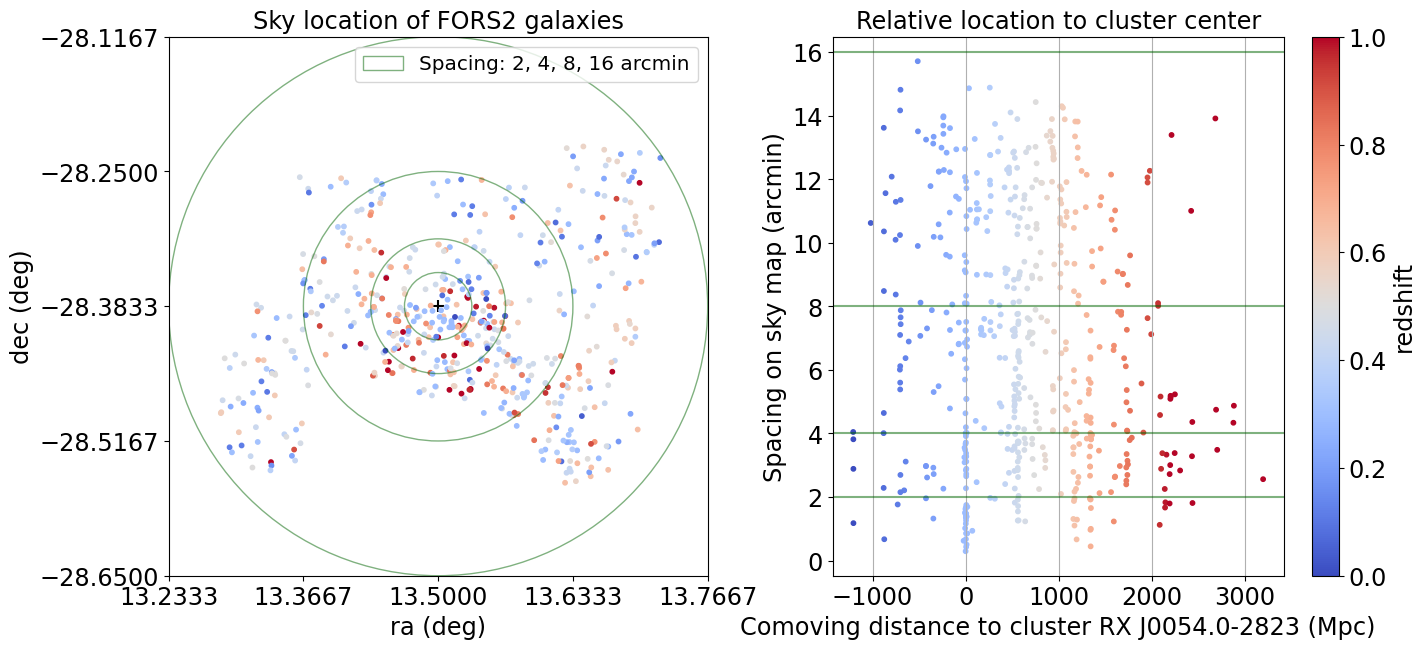

In [46]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
a1,a2 = axs.ravel()
a1.set_box_aspect(1.)
a1.scatter(ra0*180/np.pi,dec0*180/np.pi,c='k',marker='+', s=81, alpha=1)
a1.scatter(all_ra[_sel], all_dec[_sel],c=all_colors2, edgecolors=all_colors2, s=10,marker="o",alpha=1)
#im = ax.scatter(all_ra,all_dec,c=all_redshifts,s=10,marker="o",alpha=0.5,cmap="jet")
#a1.grid()
c1=plt.Circle((ra0*180/np.pi,dec0*180/np.pi), 2./60, fill=False, alpha=0.5, color='darkgreen', label="Spacing: 2, 4, 8, 16 arcmin")
c2=plt.Circle((ra0*180/np.pi,dec0*180/np.pi), 4./60, fill=False, alpha=0.5, color='darkgreen')
c3=plt.Circle((ra0*180/np.pi,dec0*180/np.pi), 8./60, fill=False, alpha=0.5, color='darkgreen')
c4=plt.Circle((ra0*180/np.pi,dec0*180/np.pi), 16./60, fill=False, alpha=0.5, color='darkgreen')
a1.add_artist(c1)
a1.add_artist(c2)
a1.add_artist(c3)
a1.add_artist(c4)
a1.set_xticks(np.linspace(ra0*180/np.pi-16/60, ra0*180/np.pi+16/60, 5))
a1.set_yticks(np.linspace(dec0*180/np.pi-16/60, dec0*180/np.pi+16/60, 5))
a1.set_xlabel("ra (deg)")
a1.set_ylabel("dec (deg)")
a1.set_title("Sky location of FORS2 galaxies")
a1.legend()

a2.scatter(all_dists,angles_to_center*60,c=all_colors2, edgecolors=all_colors2, s=10,marker="o",alpha=1)
#im = ax.scatter(all_ra,all_dec,c=all_redshifts,s=10,marker="o",alpha=0.5,cmap="jet")
a2.axhline(2., alpha=0.5, color='darkgreen')
a2.axhline(4., alpha=0.5, color='darkgreen')
a2.axhline(8., alpha=0.5, color='darkgreen')
a2.axhline(16., alpha=0.5, color='darkgreen')
a2.grid(True, axis='x')
a2.set_xlabel("Comoving distance to cluster RX J0054.0-2823 (Mpc)")
a2.set_ylabel("Spacing on sky map (arcmin)")
a2.set_title("Relative location to cluster center")

cbar = fig.colorbar(scalarMap2, ax=a2)
cbar.set_label('redshift')

/tmp/ipykernel_32346/1880353818.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(scalarMap2)


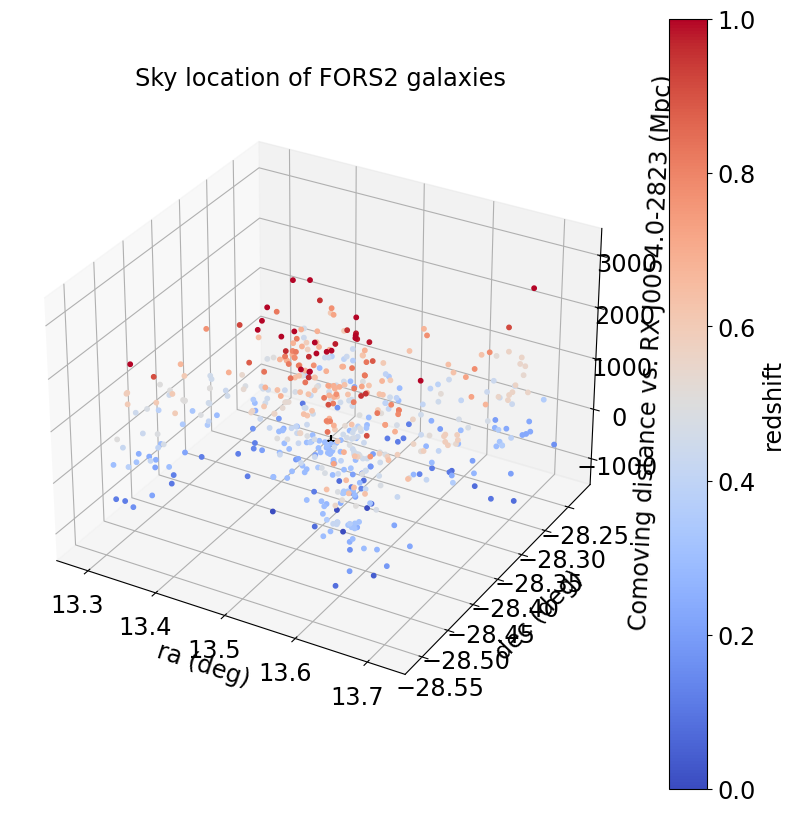

In [47]:
fig = plt.figure(figsize=(10,10))
a1 = fig.add_subplot(projection='3d')
#a1.set_box_aspect(1.)
a1.scatter(ra0*180/np.pi, dec0*180/np.pi, 0.0, c='k',marker='+', s=81, alpha=1)
a1.scatter(all_ra[_sel], all_dec[_sel], all_dists, c=all_colors2, edgecolors=all_colors2, s=10,marker="o",alpha=1)
a1.set_xlabel("ra (deg)")
a1.set_ylabel("dec (deg)")
a1.set_zlabel("Comoving distance vs. RX J0054.0-2823 (Mpc)")
a1.set_title("Sky location of FORS2 galaxies")
a1.tick_params(length=1)
cbar = fig.colorbar(scalarMap2)
cbar.set_label('redshift')

Text(0.5, 1.0, 'Relative location to cluster center')

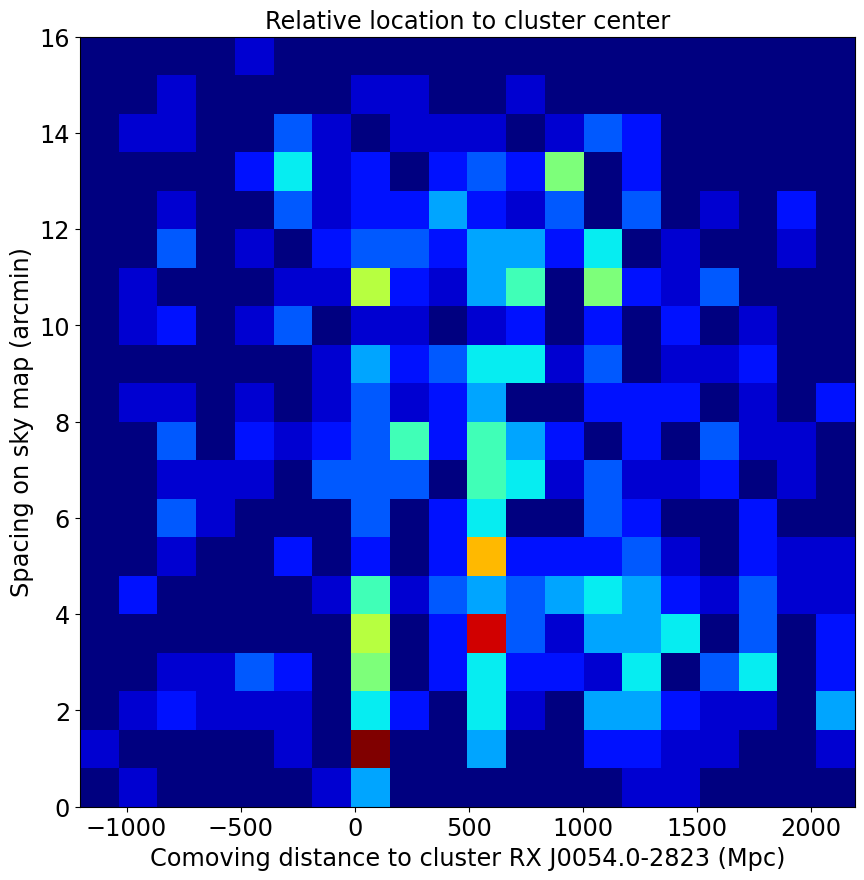

In [48]:
f,a = plt.subplots(1,1,figsize=(10,10))
a.hist2d(all_dists, angles_to_center*60,\
           range=[(comov_dist.comoving_dist(0.292, 0.)/comov_dist.mpc_m,\
                   comov_dist.comoving_dist(0.292, 1.)/comov_dist.mpc_m),\
                  (0., 16)],\
           bins=20)
a.set_xlabel("Comoving distance to cluster RX J0054.0-2823 (Mpc)")
a.set_ylabel("Spacing on sky map (arcmin)")
a.set_title("Relative location to cluster center")

# Dust reddening

In [49]:
from EmuLP import Analysis, Template, Extinction, Galaxy, Filter

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [50]:
conf_json = os.path.abspath(os.path.join('EmuLP','COSMOS2020-with-FORS2-HSC_only-jax-CC-togglePriorTrue-opa.json'))
cosmo, z_grid, fine_z_grid, wl_grid, filters_arr, named_filters, baseTemp_arr, extlaws_dict, ebv_vals, dust_arr, wls_opa, opa_zgrid, opacity_grid, obs_arr = Analysis.load_data_for_analysis(conf_json)

Loading filters :


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 209.20it/s]


Building templates :


100%|███████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 20.14it/s]


Generating dust attenuations laws :


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.85it/s]


Loading IGM attenuations :
Loading observations :


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5440.43it/s]


In [51]:
extlaws_dict, ebv_vals

({'0': {'name': 'Calzetti', 'path': '../LEPHARE/ext/SB_calzetti.dat'},
  '1': {'name': 'Prevot', 'path': '../LEPHARE/ext/SMC_prevot.dat'}},
 Array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.5 ],      dtype=float32))

0.11242784632981943 292.9251916262853 451.7258271715604
0.08140638026504031 195.5458097631594 287.76330443139335
0.024348134497885348 244.93012686166554 267.36660710898127
0.22975090013813967 232.62109221817036 827.3751527299968
0.1717974779885155 293.06009514316855 615.2104641762339


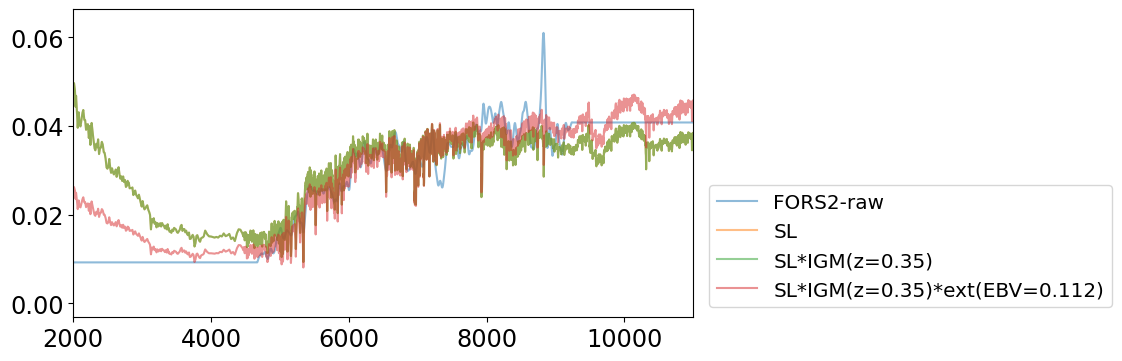

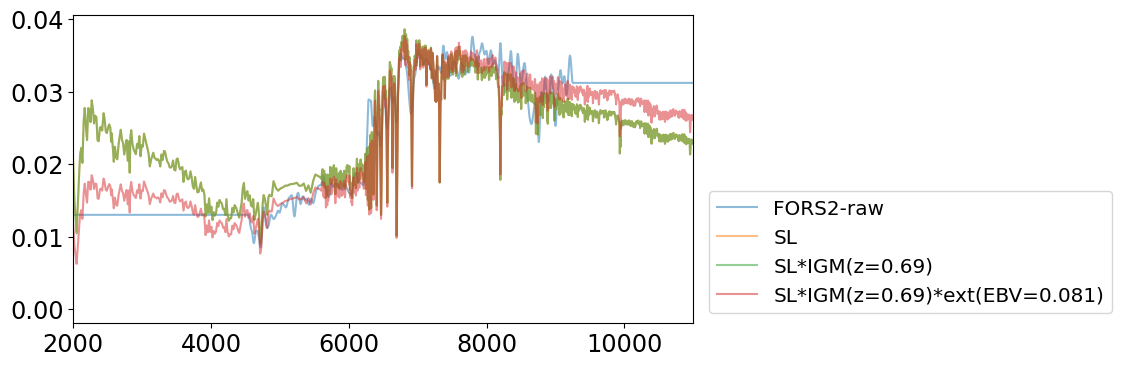

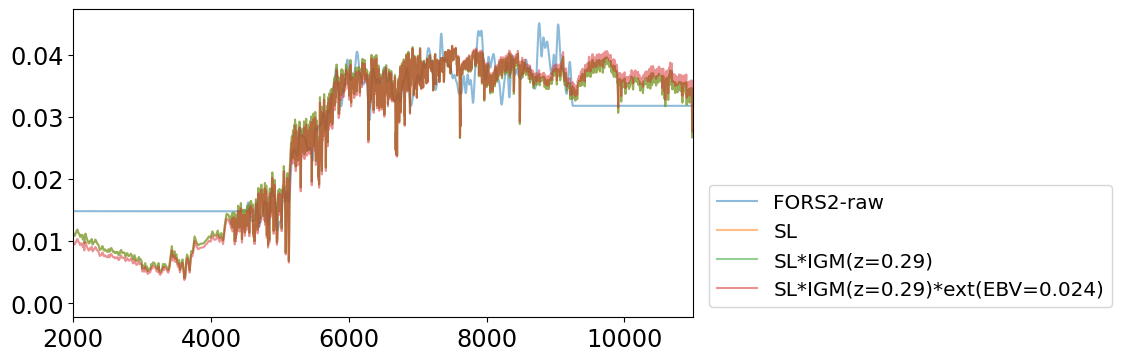

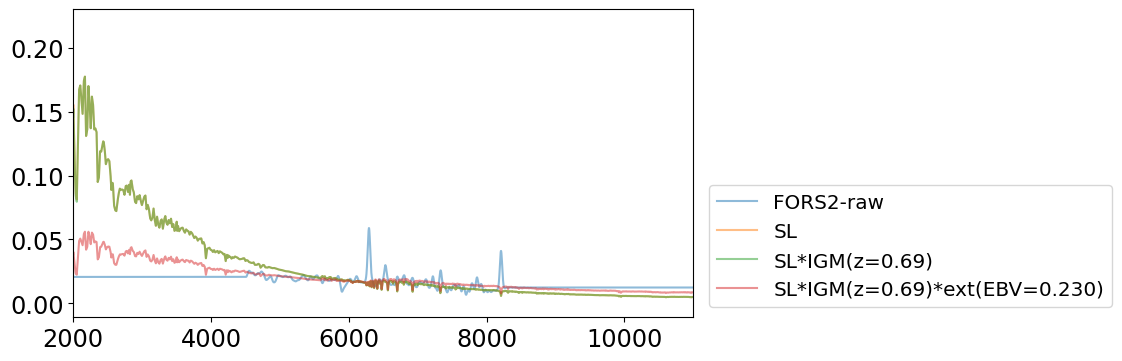

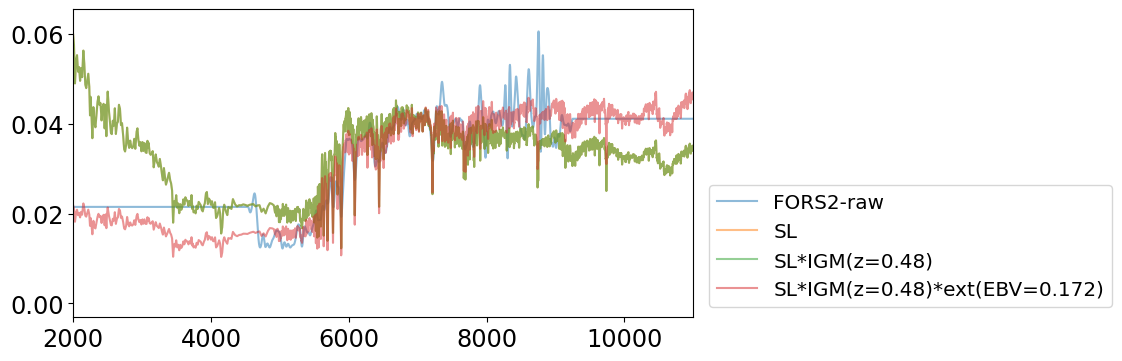

In [52]:
from scipy.optimize import curve_fit
for idx,the_num in enumerate(all_numbers[:5]):
    f,a = plt.subplots(1,1)
    z_s = all_redshifts[idx]
    
    the_wl_fors2 = all_wl[idx]
    the_flux_fors2 = all_spectra[idx]
    the_flux_fors2_filt = gaussian_filter1d(the_flux_fors2, 5)

    wlmin = the_wl_fors2.min()
    wlmax = the_wl_fors2.max()

    I1 = np.trapz(the_flux_fors2_filt ,the_wl_fors2)

    idx_sl = np.where(all_numbers_SL == the_num)[0][0]
    the_spectrum_SL = spec_SL[idx_sl]
    
    wavelengths_SL_indexes = np.where(np.logical_and(wavelengths_SL >= wlmin, wavelengths_SL < wlmax))[0]
    the_spectrum_SL_flux_cut = the_spectrum_SL[wavelengths_SL_indexes]
    the_spectrum_SL_wl_cut = wavelengths_SL[wavelengths_SL_indexes]
    I2 = np.trapz(the_spectrum_SL_flux_cut, the_spectrum_SL_wl_cut)
    g = I1/I2
    
    f2_interp = np.interp(wl_grid, the_wl_fors2, the_flux_fors2_filt)
    sl_interp = np.interp(wl_grid, wavelengths_SL, the_spectrum_SL)
    
    opa_at_z = np.array([np.interp(z_s, opa_zgrid, opacity_grid[:, _col]) for _col in range(opacity_grid.shape[1])])
    opa_at_z = np.concatenate((opa_at_z, np.ones(len(wl_grid)-len(wls_opa))))
    
    a.plot(wl_grid*(1+z_s), f2_interp, label='FORS2-raw', alpha=0.5)
    a.plot(wl_grid*(1+z_s), g*sl_interp, label='SL', alpha=0.5)
    a.plot(wl_grid*(1+z_s), g*sl_interp*opa_at_z, label=f'SL*IGM(z={z_s:.2f})', alpha=0.5)
    
    _sel_for_fit = (wl_grid > wlmin)*(wl_grid < wlmax)
    
    def f_to_fit(wl, EBV, k):
        ext_trans = Extinction.load_extinc(extlaws_dict['0']['path'], EBV, wl)
        non_ext_flux = np.interp(wl, wl_grid, sl_interp*opa_at_z)
        return k*ext_trans*non_ext_flux
    
    
    ebv_fit, scale_fit = curve_fit(f_to_fit, wl_grid[_sel_for_fit], f2_interp[_sel_for_fit], p0=(0.0, g), bounds=(0.0, np.inf))[0]
    print(ebv_fit, g, scale_fit)
    
    a.plot(wl_grid*(1+z_s), f_to_fit(wl_grid, ebv_fit, scale_fit), label=f'SL*IGM(z={z_s:.2f})*ext(EBV={ebv_fit:.3f})', alpha=0.5)
    a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0))
    a.set_xlim(2000., 11000.)

## Interprétation
Comment utiliser ça? Construction d'un prior? Sélection de templates pré-rougies par couleur?
Si prior : relier au redshift, au D4000 et au n_UV peut_être... à tester séparément en avance.

### Calcul des grandeurs dans une boucle :
nuvk, d4000n et E(B-V), à ajouter à un dataframe

100%|█████████████████████████████████████████████████████████████████████████████████| 550/550 [08:35<00:00,  1.07it/s]


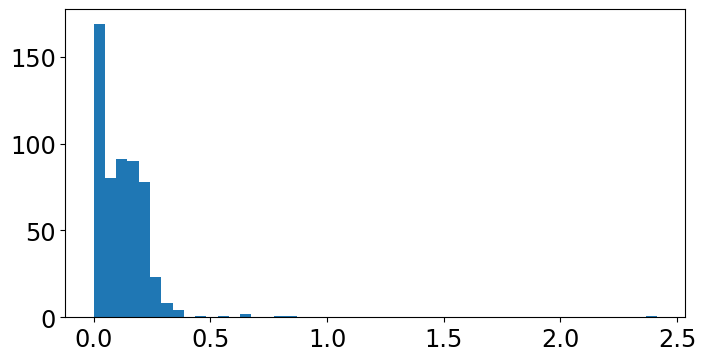

In [53]:
if True:
    all_ebvs = []
    all_d4000n = []
    all_nuvk = []
    all_types = []

    summary_props = pd.DataFrame(index=all_num)

    summary_props['RA[deg]'] = all_ra
    summary_props['DEC[deg]'] = all_dec
    summary_props['Redshift'] = all_redshifts

    _wls0 = np.arange(3600., 4300., 1.)
    d4000n0_transm = np.zeros_like(_wls0)
    d4000n0_transm[(_wls0>=3850.)*(_wls0<=3950.0)] = 1.0
    d4000n0 = Filter.sedpyFilter(96, _wls0, d4000n0_transm)

    d4000n1_transm = np.zeros_like(_wls0)
    d4000n1_transm[(_wls0>=4000.)*(_wls0<=4100.0)] = 1.0
    d4000n1 = Filter.sedpyFilter(97, _wls0, d4000n1_transm)

    for idx,the_num in enumerate(tqdm(all_num)):
        z_s = all_redshifts[idx]

        the_wl_fors2 = all_wl[idx]
        the_flux_fors2 = all_spectra[idx]
        the_flux_fors2_filt = gaussian_filter1d(the_flux_fors2, 5)

        wlmin = the_wl_fors2.min()
        wlmax = the_wl_fors2.max()

        I1 = np.trapz(the_flux_fors2_filt ,the_wl_fors2)

        idx_sl = np.where(all_numbers_SL == the_num)[0][0]
        the_spectrum_SL = spec_SL[idx_sl]

        wavelengths_SL_indexes = np.where(np.logical_and(wavelengths_SL >= wlmin, wavelengths_SL < wlmax))[0]
        the_spectrum_SL_flux_cut = the_spectrum_SL[wavelengths_SL_indexes]
        the_spectrum_SL_wl_cut = wavelengths_SL[wavelengths_SL_indexes]
        I2 = np.trapz(the_spectrum_SL_flux_cut, the_spectrum_SL_wl_cut)
        g = I1/I2

        f2_interp = np.interp(wl_grid, the_wl_fors2, the_flux_fors2_filt)
        sl_interp = np.interp(wl_grid, wavelengths_SL, the_spectrum_SL)

        opa_at_z = np.array([np.interp(z_s, opa_zgrid, opacity_grid[:, _col]) for _col in range(opacity_grid.shape[1])])
        opa_at_z = np.concatenate((opa_at_z, np.ones(len(wl_grid)-len(wls_opa))))

        _sel_for_fit = (wl_grid > wlmin)*(wl_grid < wlmax)

        def f_to_fit(wl, EBV, k):
            ext_trans = Extinction.load_extinc(extlaws_dict['0']['path'], EBV, wl)
            non_ext_flux = np.interp(wl, wl_grid, sl_interp*opa_at_z)
            return k*ext_trans*non_ext_flux


        ebv_fit, scale_fit = curve_fit(f_to_fit, wl_grid[_sel_for_fit], f2_interp[_sel_for_fit], p0=(0.0, g), bounds=(0.0, np.inf))[0]
        all_ebvs.append(ebv_fit)

        extinc = Extinction.load_extinc(extlaws_dict['0']['path'], ebv_fit, wl_grid)
        
        mags = Template.nojit_make_template(scale_fit*sl_interp, named_filters, extinc, z_s, cosmo, wl_grid, opa_at_z)
        summary_props.loc[the_num, [f'M({_f.name})' for _f in named_filters]] = mags
        
        mags_z0 = Template.nojit_make_template(scale_fit*sl_interp, named_filters, extinc, 0.001, cosmo, wl_grid, jnp.ones_like(opa_at_z))
        summary_props.loc[the_num, [f'M({_f.name})_z0' for _f in named_filters]] = mags_z0
        
        mags_noExt = Template.nojit_make_template(scale_fit*sl_interp, named_filters, jnp.ones_like(extinc), z_s, cosmo, wl_grid, opa_at_z)
        summary_props.loc[the_num, [f'M({_f.name})_e0' for _f in named_filters]] = mags_noExt
        
        mags_z0_noExt = Template.nojit_make_template(scale_fit*sl_interp, named_filters, jnp.ones_like(extinc), 0.001, cosmo, wl_grid, jnp.ones_like(opa_at_z))
        summary_props.loc[the_num, [f'M({_f.name})_z0_e0' for _f in named_filters]] = mags_z0_noExt
        
        nuvk = Template.calc_nuvk(jnp.array(sl_interp), jnp.array(extinc), wl_grid)
        all_nuvk.append(float(nuvk))
        
        if nuvk >= 4.25:
            all_types.append('E/S0')
        elif nuvk >= 3.19:
            all_types.append('Sbc')
        elif nuvk >= 1.9:
            all_types.append('Scd')
        else:
            all_types.append('Irr')

        flux_d4000 = jnp.interp(_wls0, wl_grid, jnp.array(sl_interp))
        d4000n = jnp.trapz(flux_d4000*d4000n0.transmission, x=_wls0) / jnp.trapz(flux_d4000*d4000n1.transmission, x=_wls0)
        all_d4000n.append(float(d4000n))

    summary_props['E(B-V) (Calzetti)'] = np.array(all_ebvs)
    summary_props['D4000n'] = np.array(all_d4000n)
    summary_props['NUVK'] = np.array(all_nuvk)
    summary_props['Type'] = all_types
    summary_props['Tag'] = all_tag
    summary_props['Lines'] = all_lines

    plt.hist(all_ebvs, bins=50)

In [54]:
if True:
    summary_props.to_pickle('FORS2_spectra_classif_properties.pkl')

### Compare reddened FORS2 spectra vs. data

In [55]:
summary_props = pd.read_pickle('FORS2_spectra_classif_properties.pkl')

In [56]:
summary_props

,RA[deg],DEC[deg],Redshift,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC),...,M(hsc_rHSC)_z0_e0,M(hsc_iHSC)_z0_e0,M(hsc_zHSC)_z0_e0,M(hsc_yHSC)_z0_e0,E(B-V) (Calzetti),D4000n,NUVK,Type,Tag,Lines
2,13.52997,-28.44776,0.34555,25.821886,25.921856,25.040974,23.704586,23.013096,22.630671,22.377399,...,9.887968,9.419348,9.189159,8.939938,1.124278e-01,0.731663,6.377514,E/S0,"SPEC2 , z=0.35, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
3,13.52552,-28.42080,0.68660,27.474937,27.486893,26.909842,25.811043,24.925348,24.702564,24.544174,...,10.384878,10.199041,10.113859,10.029570,8.140638e-02,0.823350,5.338274,E/S0,"SPEC3 , z=0.69, lines=[OII],H9,K,H,H{beta},[OI...","b'[OII],H9,K,H,H{beta},[OIII],H8 ..."
9,13.50219,-28.40641,0.29266,25.663216,25.914091,24.416805,23.163275,22.570648,22.297443,22.064274,...,10.226454,9.809847,9.619812,9.432680,2.434813e-02,0.643971,6.761829,E/S0,"SPEC9 , z=0.29, lines=H9,H8,K,H","b'H9,H8,K,H ..."
13,13.49261,-28.38272,0.68870,26.572910,26.594807,26.396280,26.103289,25.844692,25.799042,25.749678,...,11.081982,10.937572,10.771805,10.602051,2.297509e-01,1.034968,3.822172,Sbc,"SPEC13 , z=0.69, lines=[OII],H{epsilon},H{delt...","b'[OII],H{epsilon},H{delta},H{beta} ..."
19,13.60758,-28.43452,0.48395,26.472153,26.558479,25.837456,24.469170,23.801319,23.434643,23.226709,...,9.596317,9.217987,9.018663,8.792568,1.717975e-01,0.806435,6.399498,E/S0,"SPEC19 , z=0.48, lines=H10,H9,H8,K,H,H{delta}","b'H10,H9,H8,K,H,H{delta} ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,13.68083,-28.23290,0.23012,21.773840,21.832668,21.096130,20.369307,19.936716,19.658907,19.477705,...,7.687561,7.413023,7.260187,7.087929,1.629334e-01,0.856027,4.841396,E/S0,"SPEC734 , z=0.23, lines=[OII],H9,K,H,H{alpha},NII","b'[OII],H9,K,H,H{alpha},NII ..."
735,13.69958,-28.23161,0.36169,23.926516,24.541979,22.297907,20.770287,20.160078,19.871609,19.709585,...,7.132578,6.811829,6.653036,6.454988,6.709273e-02,0.634273,8.569615,E/S0,"SPEC735 , z=0.36, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
736,13.66431,-28.22849,0.55777,25.969648,25.999710,25.712921,25.045811,24.664101,24.482536,24.372080,...,10.285772,10.155405,10.092361,10.018002,1.912414e-01,0.957919,4.205803,Sbc,"SPEC736 , z=0.56, lines=[OII],H9,H{beta},[OIII]","b'[OII],H9,H{beta},[OIII] ..."
737,13.62722,-28.22692,0.52001,25.798443,25.905743,25.058142,23.921850,23.384155,23.156130,23.066650,...,9.813402,9.603807,9.512367,9.436058,4.692699e-22,0.785689,4.916520,E/S0,"SPEC737 , z=0.52, lines=[OII],K,H","b'[OII],K,H ..."


<AxesSubplot: xlabel='D4000n', ylabel='E(B-V) (Calzetti)'>

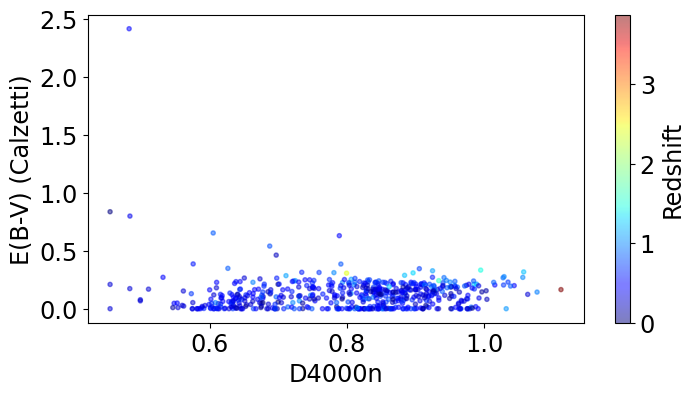

In [57]:
summary_props.plot.scatter(x='D4000n', y='E(B-V) (Calzetti)', c='Redshift', alpha=0.5, s=9)

Text(0, 0.5, 'Transmission')

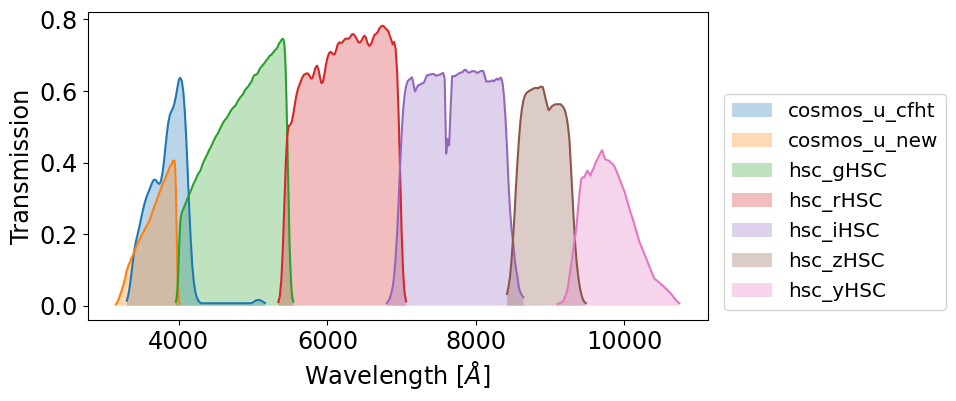

In [58]:
f,a = plt.subplots(1,1)
for filt in named_filters:
    a.fill_between(filt.wavelengths, filt.transmission, label=filt.name, alpha=0.3)
    a.plot(filt.wavelengths, filt.transmission)
a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0))
a.set_xlabel('Wavelength [$\AA$]')
a.set_ylabel('Transmission')

In [59]:
if False:
    the_num = summary_props.index[0]
    z = summary_props.loc[num, 'Redshift']
    ebv = summary_props.loc[num, 'E(B-V) (Calzetti)']
    idx_sl = np.where(all_numbers_SL == the_num)[0][0]
    the_spectrum_SL = jnp.array(spec_SL[idx_sl])
    sl_interp = jnp.interp(wl_grid, jnp.array(wavelengths_SL), the_spectrum_SL)
    opa_at_z = jnp.array([np.interp(z, opa_zgrid, opacity_grid[:, _col]) for _col in range(opacity_grid.shape[1])])
    opa_at_z = jnp.concatenate((opa_at_z, np.ones(len(wl_grid)-len(wls_opa))))
    extinc = Extinction.load_extinc(extlaws_dict['0']['path'], ebv, wl_grid)

    mags = Template.nojit_make_template(sl_interp, named_filters, extinc, z, cosmo, wl_grid, opa_at_z)
    mags

In [60]:
jet_map = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=0.5) # np.max(all_redshifts))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet_map)
all_colors = scalarMap.to_rgba(summary_props['E(B-V) (Calzetti)'], alpha=1)

/tmp/ipykernel_32346/1480798174.py:4: RuntimeWarning: invalid value encountered in log10
  a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\


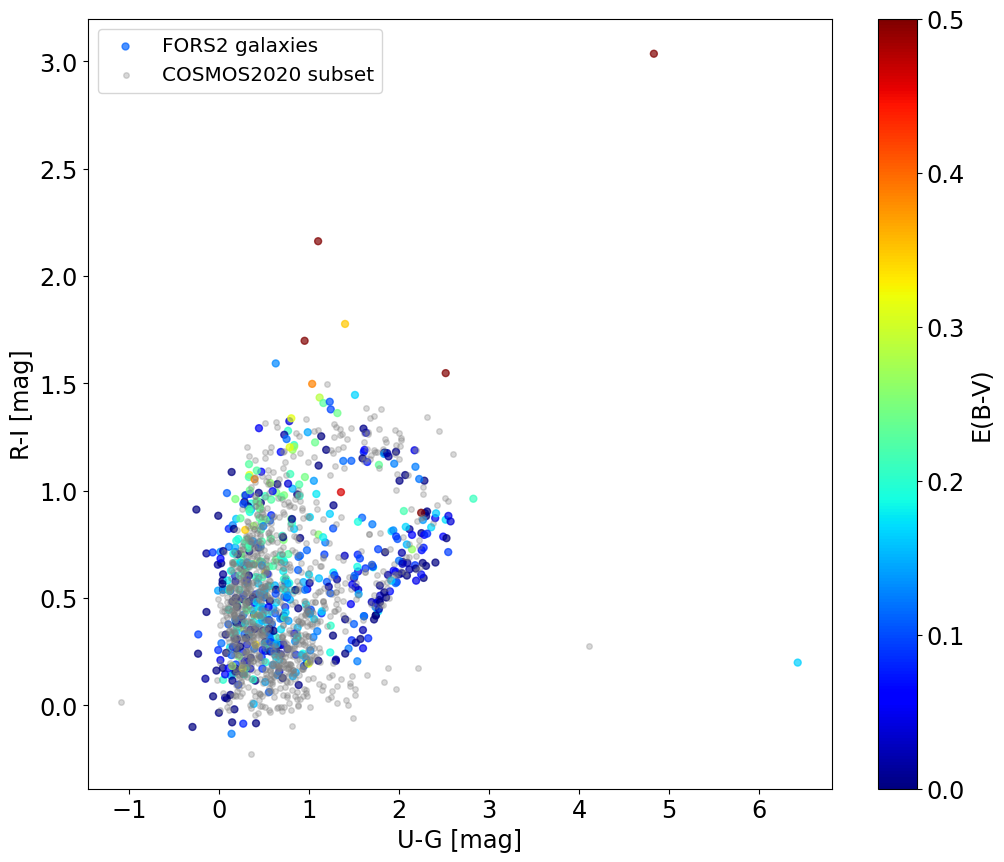

In [61]:
f,a = plt.subplots(1,1, figsize=(12,10))
a.scatter(summary_props['M(cosmos_u_new)']-summary_props['M(hsc_gHSC)'], summary_props['M(hsc_rHSC)']-summary_props['M(hsc_iHSC)'],\
          c=all_colors, alpha=0.7, s=25, label='FORS2 galaxies')
a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\
          c='grey', s=16, alpha=0.3, label='COSMOS2020 subset')

a.set_xlabel('U-G [mag]')
a.set_ylabel('R-I [mag]')
a.legend()

cbar = f.colorbar(scalarMap, ax=a)
cbar.set_label('E(B-V)')

/tmp/ipykernel_32346/886634212.py:8: RuntimeWarning: invalid value encountered in log10
  a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\


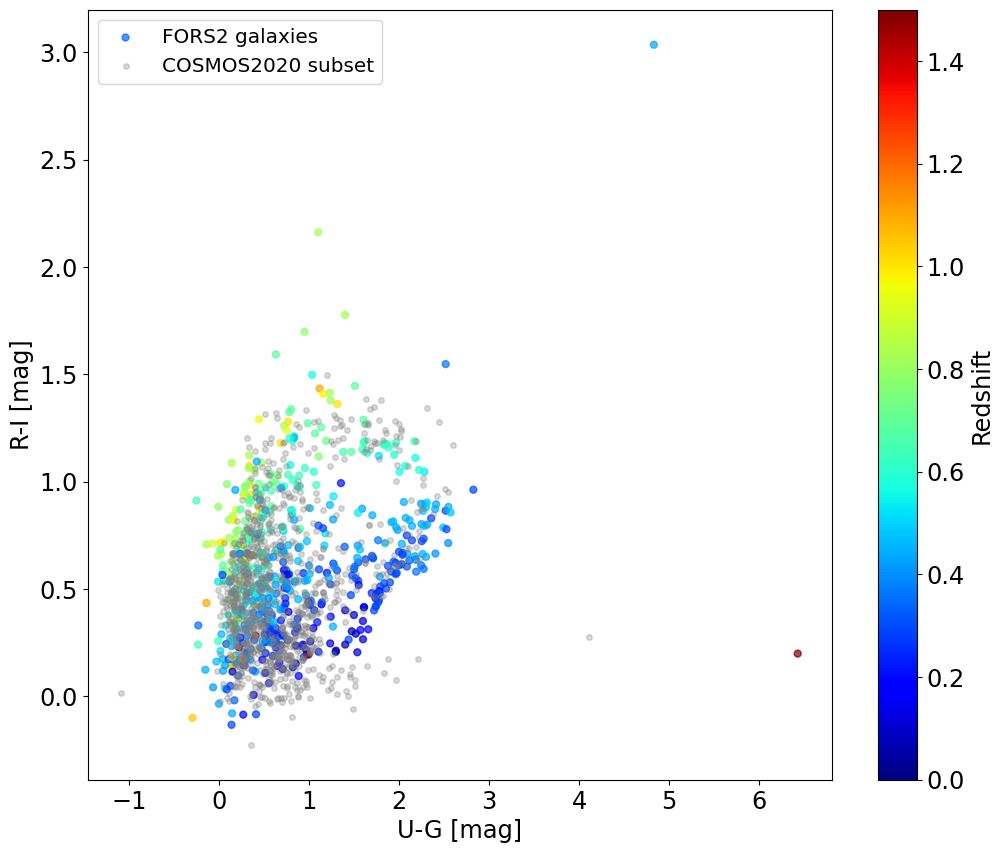

In [62]:
cNorm = colors.Normalize(vmin=0., vmax=1.5) # np.max(all_redshifts))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet_map)
all_colors = scalarMap.to_rgba(summary_props['Redshift'], alpha=1)

f,a = plt.subplots(1,1, figsize=(12,10))
a.scatter(summary_props['M(cosmos_u_new)']-summary_props['M(hsc_gHSC)'], summary_props['M(hsc_rHSC)']-summary_props['M(hsc_iHSC)'],\
          c=all_colors, alpha=0.7, s=25, label='FORS2 galaxies')
a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\
          c='grey', s=16, alpha=0.3, label='COSMOS2020 subset')

a.set_xlabel('U-G [mag]')
a.set_ylabel('R-I [mag]')
a.legend()

cbar = f.colorbar(scalarMap, ax=a)
cbar.set_label('Redshift')

/tmp/ipykernel_32346/3642368322.py:8: RuntimeWarning: invalid value encountered in log10
  a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\


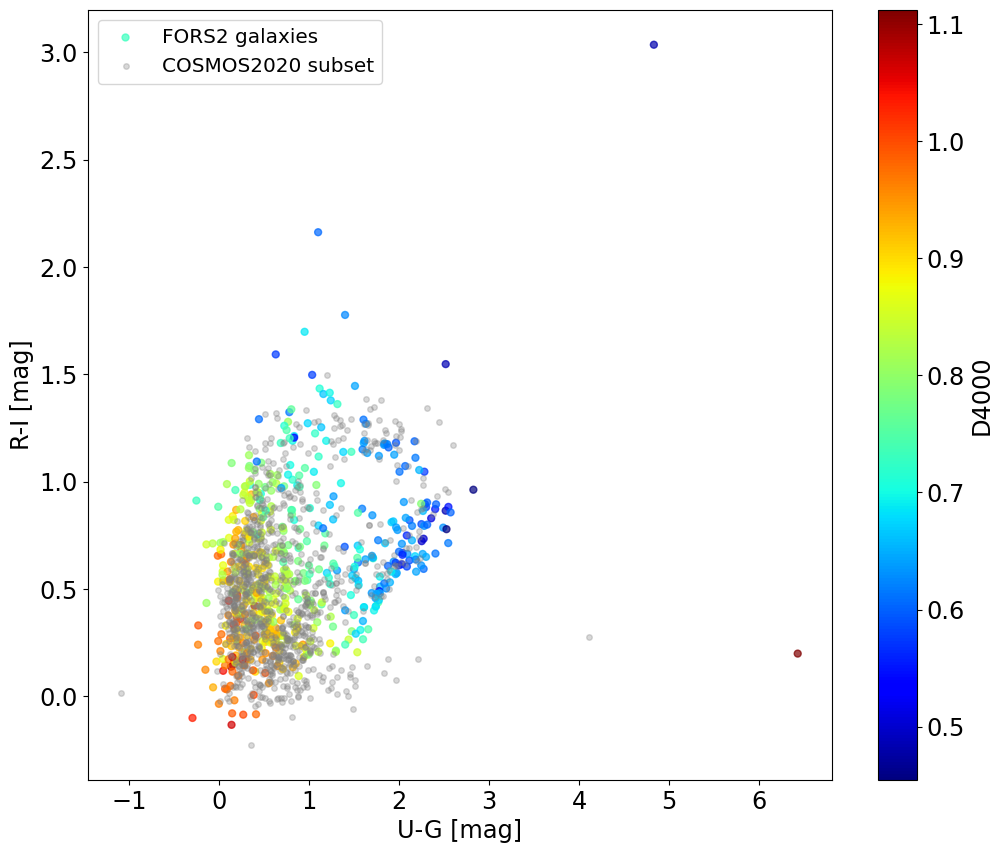

In [63]:
cNorm = colors.Normalize(vmin=np.min(summary_props['D4000n'].values), vmax=np.max(summary_props['D4000n'].values)) # np.max(all_redshifts))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet_map)
all_colors = scalarMap.to_rgba(summary_props['D4000n'], alpha=1)

f,a = plt.subplots(1,1, figsize=(12,10))
a.scatter(summary_props['M(cosmos_u_new)']-summary_props['M(hsc_gHSC)'], summary_props['M(hsc_rHSC)']-summary_props['M(hsc_iHSC)'],\
          c=all_colors, alpha=0.7, s=25, label='FORS2 galaxies')
a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\
          c='grey', s=16, alpha=0.3, label='COSMOS2020 subset')

a.set_xlabel('U-G [mag]')
a.set_ylabel('R-I [mag]')
a.legend()

cbar = f.colorbar(scalarMap, ax=a)
cbar.set_label('D4000')

/tmp/ipykernel_32346/4069359913.py:8: RuntimeWarning: invalid value encountered in log10
  a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\


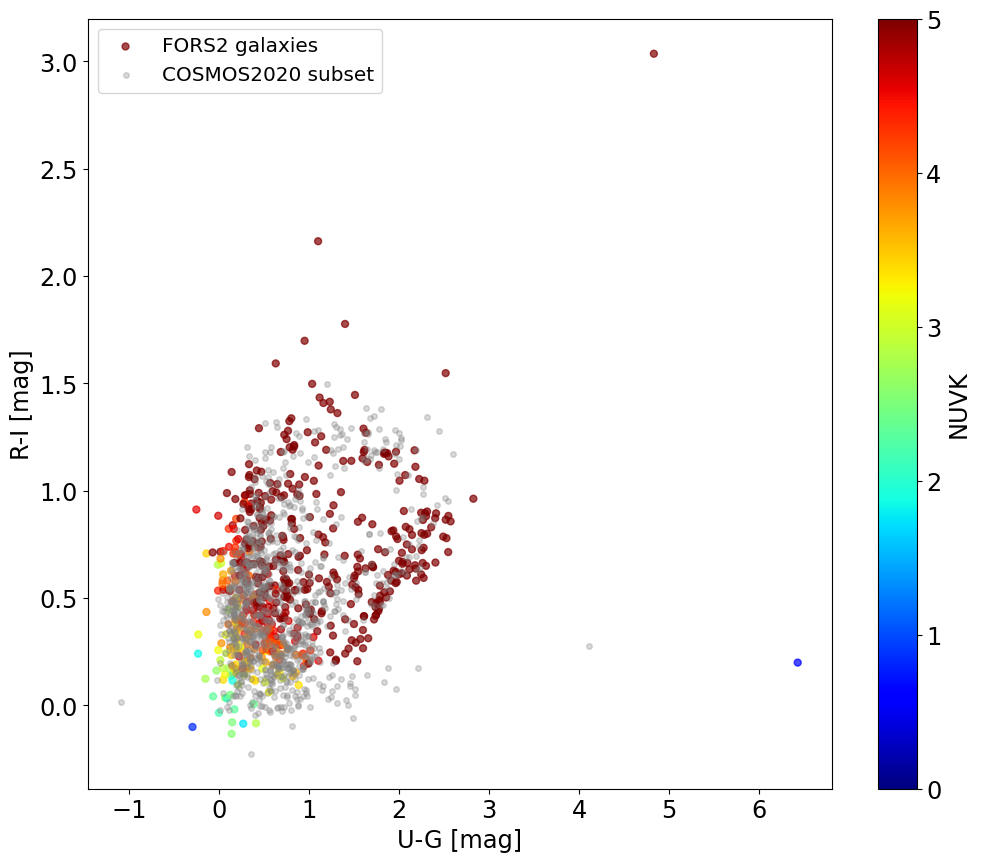

In [64]:
cNorm = colors.Normalize(vmin=0., vmax=5.) # np.max(all_redshifts))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet_map)
all_colors = scalarMap.to_rgba(summary_props['NUVK'], alpha=1)

f,a = plt.subplots(1,1, figsize=(12,10))
a.scatter(summary_props['M(cosmos_u_new)']-summary_props['M(hsc_gHSC)'], summary_props['M(hsc_rHSC)']-summary_props['M(hsc_iHSC)'],\
          c=all_colors, alpha=0.7, s=25, label='FORS2 galaxies')
a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\
          c='grey', s=16, alpha=0.3, label='COSMOS2020 subset')

a.set_xlabel('U-G [mag]')
a.set_ylabel('R-I [mag]')
a.legend()

cbar = f.colorbar(scalarMap, ax=a)
cbar.set_label('NUVK')

<AxesSubplot: xlabel='Redshift', ylabel='E(B-V) (Calzetti)'>

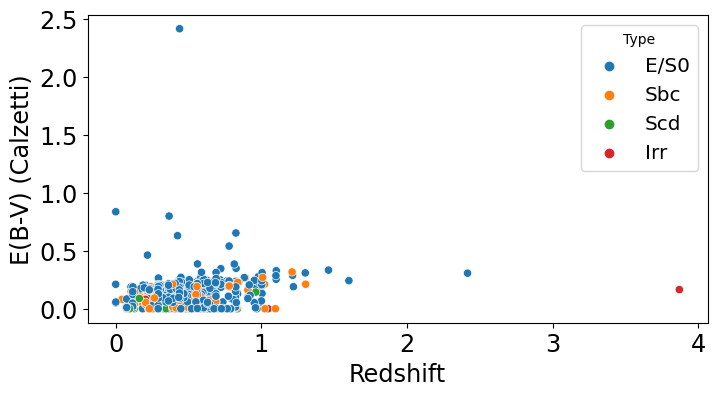

In [65]:
import seaborn as sns
sns.scatterplot(data=summary_props, x='Redshift', y='E(B-V) (Calzetti)', hue='Type')

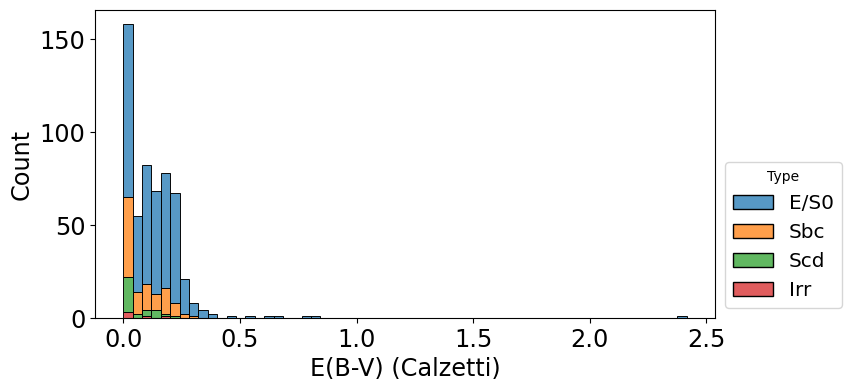

In [66]:
f,a = plt.subplots(1,1)
sns.histplot(data=summary_props, x='E(B-V) (Calzetti)', hue='Type',\
             stat='count', element='bars', multiple='stack', ax=a\
            )
sns.move_legend(a, loc='lower left', bbox_to_anchor=(1., 0.))

/tmp/ipykernel_32346/2888139620.py:8: RuntimeWarning: invalid value encountered in log10
  a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\


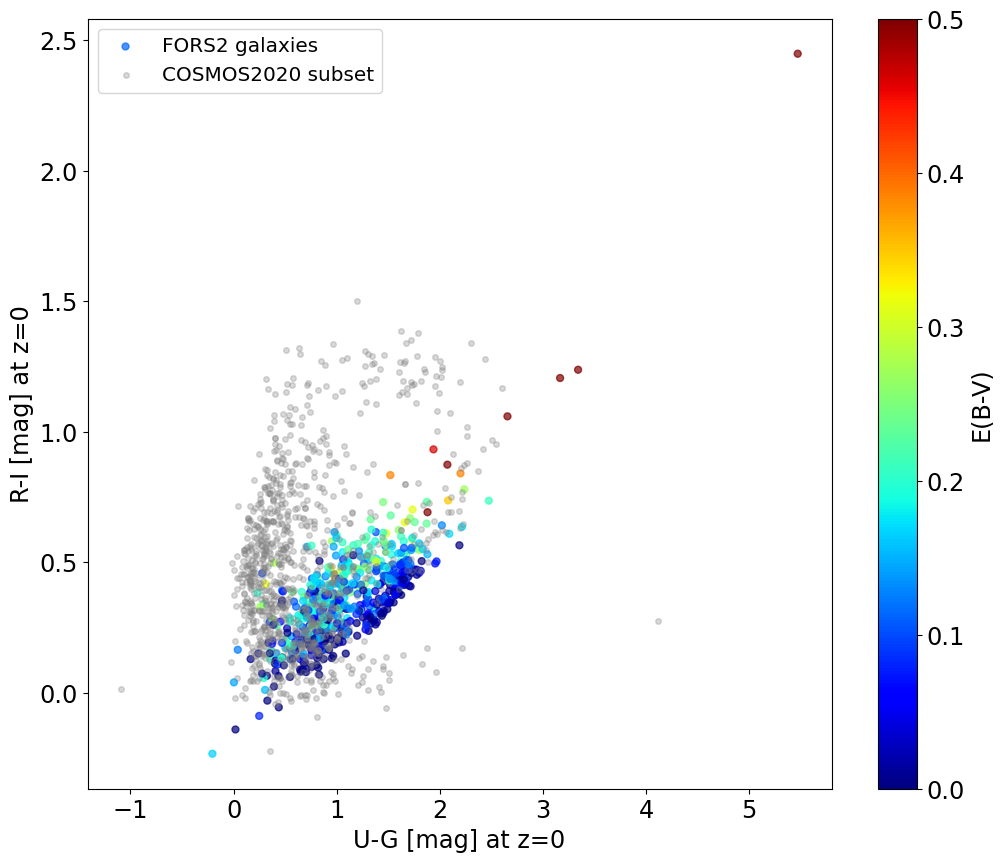

In [67]:
cNorm = colors.Normalize(vmin=0, vmax=0.5) # np.max(all_redshifts))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet_map)
all_colors = scalarMap.to_rgba(summary_props['E(B-V) (Calzetti)'], alpha=1)

f,a = plt.subplots(1,1, figsize=(12,10))
a.scatter(summary_props['M(cosmos_u_new)_z0']-summary_props['M(hsc_gHSC)_z0'], summary_props['M(hsc_rHSC)_z0']-summary_props['M(hsc_iHSC)_z0'],\
          c=all_colors, alpha=0.7, s=25, label='FORS2 galaxies')
a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\
          c='grey', s=16, alpha=0.3, label='COSMOS2020 subset')

a.set_xlabel('U-G [mag] at z=0')
a.set_ylabel('R-I [mag] at z=0')
a.legend()

cbar = f.colorbar(scalarMap, ax=a)
cbar.set_label('E(B-V)')

/tmp/ipykernel_32346/604912759.py:10: RuntimeWarning: invalid value encountered in log10
  a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\


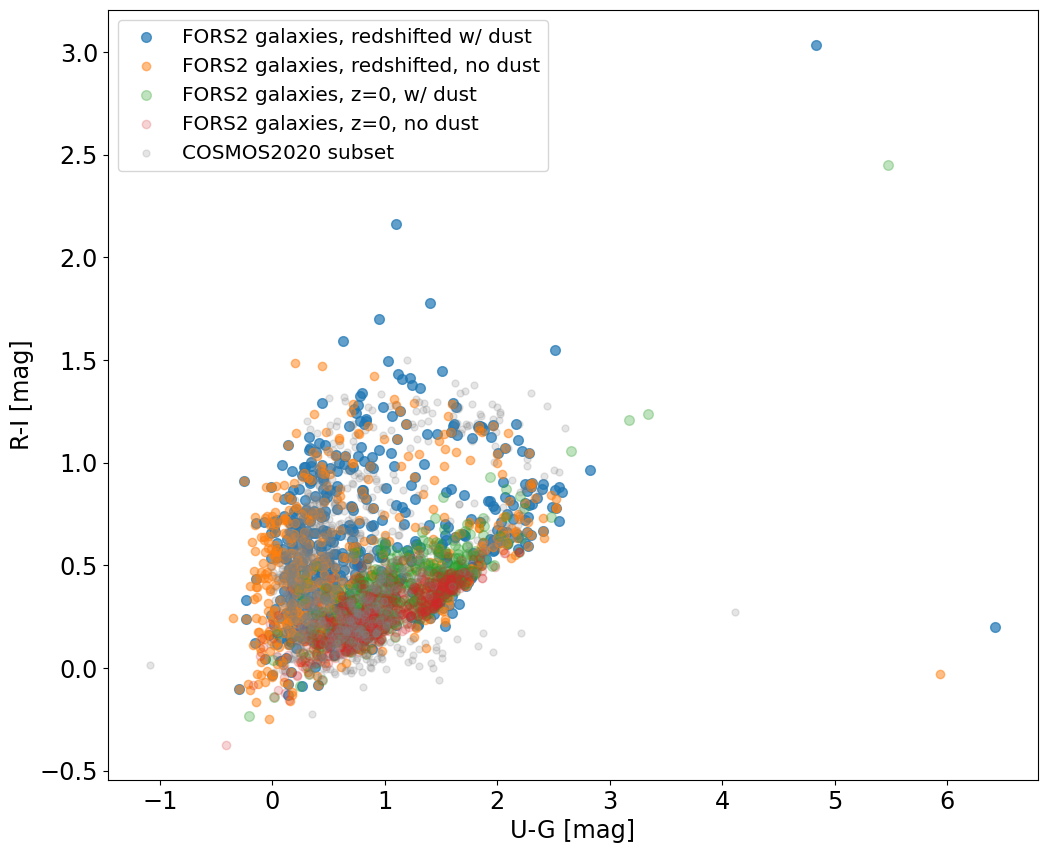

In [71]:
f,a = plt.subplots(1,1, figsize=(12,10))
a.scatter(summary_props['M(cosmos_u_new)']-summary_props['M(hsc_gHSC)'], summary_props['M(hsc_rHSC)']-summary_props['M(hsc_iHSC)'],\
          alpha=0.7, s=49, label='FORS2 galaxies, redshifted w/ dust')
a.scatter(summary_props['M(cosmos_u_new)_e0']-summary_props['M(hsc_gHSC)_e0'], summary_props['M(hsc_rHSC)_e0']-summary_props['M(hsc_iHSC)_e0'],\
          alpha=0.5, s=36, label='FORS2 galaxies, redshifted, no dust')
a.scatter(summary_props['M(cosmos_u_new)_z0']-summary_props['M(hsc_gHSC)_z0'], summary_props['M(hsc_rHSC)_z0']-summary_props['M(hsc_iHSC)_z0'],\
          alpha=0.3, s=49, label='FORS2 galaxies, z=0, w/ dust')
a.scatter(summary_props['M(cosmos_u_new)_z0_e0']-summary_props['M(hsc_gHSC)_z0_e0'], summary_props['M(hsc_rHSC)_z0_e0']-summary_props['M(hsc_iHSC)_z0_e0'],\
          alpha=0.2, s=36, label='FORS2 galaxies, z=0, no dust')
a.scatter([-2.5*np.log10(_o.AB_fluxes[1]) + 2.5*np.log10(_o.AB_fluxes[2]) for _o in obs_arr], [-2.5*np.log10(_o.AB_fluxes[3])+2.5*np.log10(_o.AB_fluxes[4]) for _o in obs_arr],\
          c='grey', s=25, alpha=0.2, label='COSMOS2020 subset')

a.set_xlabel('U-G [mag]')
a.set_ylabel('R-I [mag]')
a.legend()